<img src="https://github.com/rjpost20/Onramp-Project/blob/main/data/pexels-vishnu-r-nair-1105666.jpg?raw=true">
Image by <a href="https://www.pexels.com/@vishnurnair/" >Vishnu R Nair</a> on <a href="https://www.pexels.com/photo/people-at-concert-1105666/" >Pexels.com</a>

# *Onramp x Vanguard Spotify Project*

## By Ryan Posternak

<br>

## Imports

In [176]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from pprint import pprint
import time
import re
import collections
# import os

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import sqlite3

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')
%matplotlib inline

<br>

# Step 1: Data Ingestion

### Establish connection to Spotify's API

In [2]:
# Set API keys as environment variables (sensitive information!). Credentials are stored securely in a local file.
with open("API.txt") as f:
    text = f.readlines()
    client_id = text[0].strip()
    client_secret = text[1].strip()
    redirect_uri = text[2].strip()
    
# Assign API keys to a Spotipy credential manager
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, 
                                                      client_secret=client_secret, 
                                                      requests_timeout=100)  # Default timeout setting is too short

# Connect to Spotipy by passing in credential manager
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

sp

## Part 1: `Artist` Dataframe

### Obtain artist data for top 20 favorite artists

In [3]:
# Define list of 20 favorite artists
artists = ['Beyoncé', 'Billie Eilish', 'Bob Dylan', 'Bob Marley & The Wailers', 'Cuco', 'Doja Cat', 'Drake', \
           'Ellie Goulding', 'J. Cole', 'Jack Johnson', 'Khalid', 'Kid Cudi', 'Pink Floyd', 'Post Malone', \
           'Simon & Garfunkel', 'The Beatles', 'The Chainsmokers', 'The Weeknd', 'Tove Lo', 'blackbear']

assert len(artists) == 20

In [4]:
# Preview artist output format
preview = sp.search('The Beatles', limit=1, type='artist')
pprint(preview)

{'artists': {'href': 'https://api.spotify.com/v1/search?query=The+Beatles&type=artist&offset=0&limit=1',
             'items': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/3WrFJ7ztbogyGnTHbHJFl2'},
                        'followers': {'href': None, 'total': 23562520},
                        'genres': ['beatlesque',
                                   'british invasion',
                                   'classic rock',
                                   'merseybeat',
                                   'psychedelic rock',
                                   'rock'],
                        'href': 'https://api.spotify.com/v1/artists/3WrFJ7ztbogyGnTHbHJFl2',
                        'id': '3WrFJ7ztbogyGnTHbHJFl2',
                        'images': [{'height': 640,
                                    'url': 'https://i.scdn.co/image/ab6761610000e5ebe9348cc01ff5d55971b22433',
                                    'width': 640},
                                   {'height': 

In [5]:
# Define dictionary to contain all artist data
artists_dict = {}

# Define list containers for artists info
artist_ids = []
artist_names = []
external_urls = []
genres = []
image_urls = []
followers = []
popularities = []
types = []
artist_uris = []

# Append artist info to each respective list
for artist in artists:
    artist_info = sp.search(artist, limit=1, type='artist')
    info_items = artist_info['artists']['items'][0]
    
    artist_ids.append(info_items['id'])
    artist_names.append(info_items['name'])
    external_urls.append(info_items['external_urls']['spotify'])
    genres.append(info_items['genres'][0])  # Take first genre from list
    image_urls.append(info_items['images'][0]['url'])  # Take first image url from list
    followers.append(info_items['followers']['total'])
    popularities.append(info_items['popularity'])
    types.append(info_items['type'])
    artist_uris.append(info_items['uri'])
    
    # Set a delay after each API call just to be safe (don't want to get in trouble with the API!)
    time.sleep(0.1)

# Add lists to dictionary holding compiled artist data
artists_dict['artist_id'] = artist_ids
artists_dict['artist_name'] = artist_names
artists_dict['external_url'] = external_urls
artists_dict['genre'] = genres
artists_dict['image_url'] = image_urls
artists_dict['followers'] = followers
artists_dict['popularity'] = popularities
artists_dict['type'] = types
artists_dict['artist_uri'] = artist_uris

In [6]:
# Compile into Pandas dataframe
artists_df = pd.DataFrame(data=artists_dict)
assert artists_df.shape[0] == 20

# Preview artists dataframe
artists_df.head()

,artist_id,artist_name,external_url,genre,image_url,followers,popularity,type,artist_uri
0,6vWDO969PvNqNYHIOW5v0m,Beyoncé,https://open.spotify.com/artist/6vWDO969PvNqNY...,dance pop,https://i.scdn.co/image/ab6761610000e5eb676338...,32143795,88,artist,spotify:artist:6vWDO969PvNqNYHIOW5v0m
1,6qqNVTkY8uBg9cP3Jd7DAH,Billie Eilish,https://open.spotify.com/artist/6qqNVTkY8uBg9c...,art pop,https://i.scdn.co/image/ab6761610000e5ebd8b998...,68743016,88,artist,spotify:artist:6qqNVTkY8uBg9cP3Jd7DAH
2,74ASZWbe4lXaubB36ztrGX,Bob Dylan,https://open.spotify.com/artist/74ASZWbe4lXaub...,album rock,https://i.scdn.co/image/ab6772690000c46cf79ca0...,5778277,71,artist,spotify:artist:74ASZWbe4lXaubB36ztrGX
3,2QsynagSdAqZj3U9HgDzjD,Bob Marley & The Wailers,https://open.spotify.com/artist/2QsynagSdAqZj3...,reggae,https://i.scdn.co/image/b5aae2067db80f694a980e...,10857854,78,artist,spotify:artist:2QsynagSdAqZj3U9HgDzjD
4,2Tglaf8nvDzwSQnpSrjLHP,Cuco,https://open.spotify.com/artist/2Tglaf8nvDzwSQ...,bedroom pop,https://i.scdn.co/image/ab6761610000e5ebcfb53b...,1846916,71,artist,spotify:artist:2Tglaf8nvDzwSQnpSrjLHP


<br>

## Part 2: `Album` Dataframe

### Obtain album data for six albums for each of top 20 favorite artists

In [7]:
# Preview albums output format
preview = sp.artist_albums(artist_id='6vWDO969PvNqNYHIOW5v0m', limit=10, country='US')
pprint(preview['items'][0])

{'album_group': 'album',
 'album_type': 'album',
 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/6vWDO969PvNqNYHIOW5v0m'},
              'href': 'https://api.spotify.com/v1/artists/6vWDO969PvNqNYHIOW5v0m',
              'id': '6vWDO969PvNqNYHIOW5v0m',
              'name': 'Beyoncé',
              'type': 'artist',
              'uri': 'spotify:artist:6vWDO969PvNqNYHIOW5v0m'}],
 'external_urls': {'spotify': 'https://open.spotify.com/album/6FJxoadUE4JNVwWHghBwnb'},
 'href': 'https://api.spotify.com/v1/albums/6FJxoadUE4JNVwWHghBwnb',
 'id': '6FJxoadUE4JNVwWHghBwnb',
 'images': [{'height': 640,
             'url': 'https://i.scdn.co/image/ab67616d0000b2730e58a0f8308c1ad403d105e7',
             'width': 640},
            {'height': 300,
             'url': 'https://i.scdn.co/image/ab67616d00001e020e58a0f8308c1ad403d105e7',
             'width': 300},
            {'height': 64,
             'url': 'https://i.scdn.co/image/ab67616d000048510e58a0f8308c1ad403d105e7'

In [8]:
# Display names of albums
for album in preview['items']:
    pprint(album['name'])

'RENAISSANCE'
'RENAISSANCE'
'The Lion King: The Gift [Deluxe Edition]'
'The Lion King: The Gift [Deluxe Edition]'
'The Lion King: The Gift'
'HOMECOMING: THE LIVE ALBUM'
'HOMECOMING: THE LIVE ALBUM'
'Lemonade'
'Lemonade'
'BEYONCÉ [Platinum Edition]'


**Remarks:**
- It looks like duplicate albums will be an issue. Further, it looks like slight variations on the name or edition (e.g. regular edition vs. deluxe edition) will also be an issue. We'll address this with a RegEx search to remove any text inside square brackets or parentheses when checking for duplicate albums, which should catch most of these duplicates.
- While not a problem for this artist, many artist will likely have one or more live-recorded versions of albums among the mix, which one would assume are almost entirely repeats of songs that are in one of their other (recorded) albums. To address this, we'll skip any album with the word "live" in it. Since this could mean losing a lot of albums, we'll set a relatively high limit of 20 in the API search.

In [9]:
# Display names of albums with album variation comments removed
for album in preview['items']:
    pprint(re.sub("[\(\[].*?[\)\]]", "", album['name']).strip())

'RENAISSANCE'
'RENAISSANCE'
'The Lion King: The Gift'
'The Lion King: The Gift'
'The Lion King: The Gift'
'HOMECOMING: THE LIVE ALBUM'
'HOMECOMING: THE LIVE ALBUM'
'Lemonade'
'Lemonade'
'BEYONCÉ'


Below I structure an API call of 20 albums per artist, however I break the loop once 7 albums have been retrieved. I call 20 in the API because I skip all identically named albums (after RegEx search above) as well as albums with the word "live" in them.

In [10]:
# Define dictionary to contain all album data
albums_dict = {}

# Set up containers for albums info
album_ids = []
album_names = []
external_urls = []
image_urls = []
release_dates = []
total_tracks = []
types = []
album_uris = []
album_artist_ids = []

# Append album info to each respective list
for artist_id in artist_ids:
    # API call for 20 albums by artist (need to account for skipped albums)
    albums_info = sp.artist_albums(artist_id=artist_id, limit=20, country='US')
    
    # Prevent duplicate albums from being added
    dup_album_check = []
    
    # Retrieve info for each album
    for album in albums_info['items']:

        unique_album_name = re.sub("[\(\[].*?[\)\]]", "", album['name']).strip()
        if unique_album_name in dup_album_check:  # Skip album if in dup_album_check list
            continue
        if 'live' in album['name'].lower():  # Skip album if 'live' in album title
            continue

        album_ids.append(album['id'])
        album_names.append(album['name'])
        external_urls.append(album['external_urls']['spotify'])
        image_urls.append(album['images'][0]['url'])  # Take first image url from list
        release_dates.append(album['release_date'])
        total_tracks.append(album['total_tracks'])
        types.append(album['type'])
        album_uris.append(album['uri'])
        album_artist_ids.append(artist_id)

        dup_album_check.append(unique_album_name)
        if len(dup_album_check) == 7:  # Set maximum number of albums per artists to 7
            break
    
    # Set a delay after each API call
    time.sleep(0.1)
    
# Add lists to dictionary holding compiled albums data
albums_dict['album_id'] = album_ids
albums_dict['album_name'] = album_names
albums_dict['external_url'] = external_urls
albums_dict['image_url'] = image_urls
albums_dict['release_date'] = release_dates
albums_dict['total_tracks'] = total_tracks
albums_dict['type'] = types
albums_dict['album_uri'] = album_uris
albums_dict['artist_id'] = album_artist_ids

In [11]:
# Compile into Pandas dataframe
albums_df = pd.DataFrame(data=albums_dict)
assert set(artist_ids) == set(album_artist_ids)  # Verify we retrieved albums for all 20 artists

# Preview albums dataframe
print('Albums:', albums_df.shape[0])
albums_df.head()

Albums: 139


,album_id,album_name,external_url,image_url,release_date,total_tracks,type,album_uri,artist_id
0,6FJxoadUE4JNVwWHghBwnb,RENAISSANCE,https://open.spotify.com/album/6FJxoadUE4JNVwW...,https://i.scdn.co/image/ab67616d0000b2730e58a0...,2022-07-29,16,album,spotify:album:6FJxoadUE4JNVwWHghBwnb,6vWDO969PvNqNYHIOW5v0m
1,7kUuNU2LRmr9XbwLHXU9UZ,The Lion King: The Gift [Deluxe Edition],https://open.spotify.com/album/7kUuNU2LRmr9Xbw...,https://i.scdn.co/image/ab67616d0000b27360e232...,2020-07-31,17,album,spotify:album:7kUuNU2LRmr9XbwLHXU9UZ,6vWDO969PvNqNYHIOW5v0m
2,7dK54iZuOxXFarGhXwEXfF,Lemonade,https://open.spotify.com/album/7dK54iZuOxXFarG...,https://i.scdn.co/image/ab67616d0000b27389992f...,2016-04-23,13,album,spotify:album:7dK54iZuOxXFarGhXwEXfF,6vWDO969PvNqNYHIOW5v0m
3,2UJwKSBUz6rtW4QLK74kQu,BEYONCÉ [Platinum Edition],https://open.spotify.com/album/2UJwKSBUz6rtW4Q...,https://i.scdn.co/image/ab67616d0000b2730d1d6e...,2014-11-24,20,album,spotify:album:2UJwKSBUz6rtW4QLK74kQu,6vWDO969PvNqNYHIOW5v0m
4,1gIC63gC3B7o7FfpPACZQJ,4,https://open.spotify.com/album/1gIC63gC3B7o7Ff...,https://i.scdn.co/image/ab67616d0000b273ff5429...,2011-06-24,14,album,spotify:album:1gIC63gC3B7o7FfpPACZQJ,6vWDO969PvNqNYHIOW5v0m


<br>

## Part 3: `Track` Dataframe

### Obtain track data for 20 tracks (minus duplicates) in each album obtained above

In [12]:
# Preview tracks output format
preview = sp.album_tracks(album_id='6FJxoadUE4JNVwWHghBwnb', limit=10, market='US')
pprint(preview['items'][0])

{'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/6vWDO969PvNqNYHIOW5v0m'},
              'href': 'https://api.spotify.com/v1/artists/6vWDO969PvNqNYHIOW5v0m',
              'id': '6vWDO969PvNqNYHIOW5v0m',
              'name': 'Beyoncé',
              'type': 'artist',
              'uri': 'spotify:artist:6vWDO969PvNqNYHIOW5v0m'}],
 'disc_number': 1,
 'duration_ms': 208014,
 'explicit': True,
 'external_urls': {'spotify': 'https://open.spotify.com/track/1MpCaOeUWhox2Fgigbe1cL'},
 'href': 'https://api.spotify.com/v1/tracks/1MpCaOeUWhox2Fgigbe1cL',
 'id': '1MpCaOeUWhox2Fgigbe1cL',
 'is_local': False,
 'is_playable': True,
 'name': "I'M THAT GIRL",
 'preview_url': 'https://p.scdn.co/mp3-preview/c7cece6b1b9cb3637fc48924f23baf9c7e1ec15c?cid=a3c3419e623d4410ad1aadf01bc737d5',
 'track_number': 1,
 'type': 'track',
 'uri': 'spotify:track:1MpCaOeUWhox2Fgigbe1cL'}


In [13]:
# Display names of 10 songs
for track in preview['items']:
    pprint(track['name'])

"I'M THAT GIRL"
'COZY'
'ALIEN SUPERSTAR'
'CUFF IT'
'ENERGY (feat. Beam)'
'BREAK MY SOUL'
'CHURCH GIRL'
'PLASTIC OFF THE SOFA'
"VIRGO'S GROOVE"
'MOVE (feat. Grace Jones & Tems)'


**Remarks:**
- It looks like duplicate songs might not be as big an issue with track searches. I don't see a need to use a RegEx search like in the last API call, but we'll still check for identically named songs and skip those.

In [14]:
# Define dictionary to contain all tracks data
tracks_dict = {}

# Set up containers for tracks info
track_ids = []
song_names = []
external_urls = []
durations_ms = []
explicit = []
disc_numbers = []
types = []
song_uris = []
track_album_ids = []

# Append track info to each respective list
for album_id in album_ids:
    # API call for (max) 20 tracks per album
    tracks_info = sp.album_tracks(album_id=album_id, limit=20, market='US')
    
    # Prevent duplicate tracks from being added
    dup_track_check = []
    
    # Retrieve info for each album
    for track in tracks_info['items']:
        
        track_name = track['name']
        if track_name in dup_track_check:  # Skip track if in dup_track_check list
            continue
            
        track_ids.append(track['id'])
        song_names.append(track['name'])
        external_urls.append(track['external_urls']['spotify'])
        durations_ms.append(track['duration_ms'])
        explicit.append(track['explicit'])
        disc_numbers.append(track['disc_number'])
        types.append(track['type'])
        song_uris.append(track['uri'])
        track_album_ids.append(album_id)
        
        dup_track_check.append(track_name)
    
    # Set a delay after each API call
    time.sleep(0.01)
    
# Add lists to dictionary holding compiled tracks data
tracks_dict['track_id'] = track_ids
tracks_dict['song_name'] = song_names
tracks_dict['external_url'] = external_urls
tracks_dict['duration_ms'] = durations_ms
tracks_dict['explicit'] = explicit
tracks_dict['disc_number'] = disc_numbers
tracks_dict['type'] = types
tracks_dict['song_uri'] = song_uris
tracks_dict['album_id'] = track_album_ids

In [15]:
# Compile into Pandas dataframe
tracks_df = pd.DataFrame(data=tracks_dict)
assert set(album_ids) == set(track_album_ids)  # Verify we retrieved tracks for all 135 albums

# Preview tracks dataframe
print('Tracks:', tracks_df.shape[0])
tracks_df.head()

Tracks: 1715


,track_id,song_name,external_url,duration_ms,explicit,disc_number,type,song_uri,album_id
0,1MpCaOeUWhox2Fgigbe1cL,I'M THAT GIRL,https://open.spotify.com/track/1MpCaOeUWhox2Fg...,208014,True,1,track,spotify:track:1MpCaOeUWhox2Fgigbe1cL,6FJxoadUE4JNVwWHghBwnb
1,0mKGwFMHzTprtS2vpR3b6s,COZY,https://open.spotify.com/track/0mKGwFMHzTprtS2...,210372,True,1,track,spotify:track:0mKGwFMHzTprtS2vpR3b6s,6FJxoadUE4JNVwWHghBwnb
2,1Hohk6AufHZOrrhMXZppax,ALIEN SUPERSTAR,https://open.spotify.com/track/1Hohk6AufHZOrrh...,215459,True,1,track,spotify:track:1Hohk6AufHZOrrhMXZppax,6FJxoadUE4JNVwWHghBwnb
3,1xzi1Jcr7mEi9K2RfzLOqS,CUFF IT,https://open.spotify.com/track/1xzi1Jcr7mEi9K2...,225388,True,1,track,spotify:track:1xzi1Jcr7mEi9K2RfzLOqS,6FJxoadUE4JNVwWHghBwnb
4,0314PeD1sQNonfVWix3B2K,ENERGY (feat. Beam),https://open.spotify.com/track/0314PeD1sQNonfV...,116727,False,1,track,spotify:track:0314PeD1sQNonfVWix3B2K,6FJxoadUE4JNVwWHghBwnb


<br>

## Part 4: `Track_Feature` Dataframe

### Obtain track features data for each of the 1,715 tracks obtained above

In [16]:
# Preview track features output format
preview = sp.audio_features('1MpCaOeUWhox2Fgigbe1cL')[0]
pprint(preview)

{'acousticness': 0.0616,
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/1MpCaOeUWhox2Fgigbe1cL',
 'danceability': 0.554,
 'duration_ms': 208014,
 'energy': 0.535,
 'id': '1MpCaOeUWhox2Fgigbe1cL',
 'instrumentalness': 1.32e-05,
 'key': 5,
 'liveness': 0.124,
 'loudness': -8.959,
 'mode': 0,
 'speechiness': 0.186,
 'tempo': 105.865,
 'time_signature': 4,
 'track_href': 'https://api.spotify.com/v1/tracks/1MpCaOeUWhox2Fgigbe1cL',
 'type': 'audio_features',
 'uri': 'spotify:track:1MpCaOeUWhox2Fgigbe1cL',
 'valence': 0.136}


In [17]:
# Define dictionary to contain all track features data
track_features_dict = {}

# Set up containers for tracks info
track_features_track_ids = []
danceability = []
energy = []
instrumentalness = []
liveness = []
loudness = []
speechiness = []
tempo = []
types = []
valence = []
track_features_song_uris = []

# Append track features info to each respective list
for track_id in track_ids:
    # API call for track features info
    track_features = sp.audio_features(track_id)[0]
    
    track_features_track_ids.append(track_id)
    danceability.append(track_features['danceability'])
    energy.append(track_features['energy'])
    instrumentalness.append(track_features['instrumentalness'])
    liveness.append(track_features['liveness'])
    loudness.append(track_features['loudness'])
    speechiness.append(track_features['speechiness'])
    tempo.append(track_features['tempo'])
    types.append(track_features['type'])
    valence.append(track_features['valence'])
    track_features_song_uris.append(track_features['uri'])
    
# Add lists to dictionary holding compiled track features data
track_features_dict['track_id'] = track_features_track_ids
track_features_dict['danceability'] = danceability
track_features_dict['energy'] = energy
track_features_dict['instrumentalness'] = instrumentalness
track_features_dict['liveness'] = liveness
track_features_dict['loudness'] = loudness
track_features_dict['speechiness'] = speechiness
track_features_dict['tempo'] = tempo
track_features_dict['type'] = types
track_features_dict['valence'] = valence
track_features_dict['song_uri'] = track_features_song_uris

In [18]:
# Compile into Pandas dataframe
track_features_df = pd.DataFrame(data=track_features_dict)
assert set(track_ids) == set(track_features_track_ids)  # Verify we retrieved track features for all 1,715 tracks

# Preview tracks dataframe
print('Track features:', track_features_df.shape[0])
track_features_df.head()

Track features: 1715


,track_id,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,type,valence,song_uri
0,1MpCaOeUWhox2Fgigbe1cL,0.554,0.535,0.000013,0.1240,-8.959,0.1860,105.865,audio_features,0.136,spotify:track:1MpCaOeUWhox2Fgigbe1cL
1,0mKGwFMHzTprtS2vpR3b6s,0.556,0.630,0.004680,0.1550,-8.150,0.1020,149.147,audio_features,0.367,spotify:track:0mKGwFMHzTprtS2vpR3b6s
2,1Hohk6AufHZOrrhMXZppax,0.545,0.641,0.000066,0.1710,-6.398,0.0998,121.892,audio_features,0.464,spotify:track:1Hohk6AufHZOrrhMXZppax
3,1xzi1Jcr7mEi9K2RfzLOqS,0.780,0.689,0.000010,0.0698,-5.668,0.1410,115.042,audio_features,0.642,spotify:track:1xzi1Jcr7mEi9K2RfzLOqS
4,0314PeD1sQNonfVWix3B2K,0.903,0.519,0.000106,0.1550,-9.151,0.2600,114.991,audio_features,0.587,spotify:track:0314PeD1sQNonfVWix3B2K


<br>

# Step 2: Data Transformation

## Part 1: Handling Null / Missing values

Below I create function to print a count of null values per column that we can use for each dataframe, as well as to print a Pandas-style "info" table

In [19]:
def display_df_null_info(dataframe):
    null_columns = [column for column in dataframe.columns if dataframe[column].isna().sum() > 0]
    
    print('Features with missing values:')
    
    if not artists_df[null_columns].isna().sum().shape[0]:  # Print 'NONE' if no columns with missing values
        print('NONE', '\n')
    else:
        print(artists_df[null_columns].isna().sum(), '\n')  # Print columns names with missing values, if any
    print('Blank values:', \
    
    # Print total number of blank values in dataframe
    sum([dataframe.loc[dataframe[column] == ''].shape[0] for column in dataframe.columns]), '\n\n')
    
    return dataframe.info()

In [20]:
display_df_null_info(artists_df)

Features with missing values:
NONE 

Blank values: 0 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   artist_id     20 non-null     object
 1   artist_name   20 non-null     object
 2   external_url  20 non-null     object
 3   genre         20 non-null     object
 4   image_url     20 non-null     object
 5   followers     20 non-null     int64 
 6   popularity    20 non-null     int64 
 7   type          20 non-null     object
 8   artist_uri    20 non-null     object
dtypes: int64(2), object(7)
memory usage: 1.5+ KB


**Remarks:**
- Looks good - no null/blank values and table schema matches the provided format.

In [21]:
display_df_null_info(albums_df)

Features with missing values:
NONE 

Blank values: 0 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139 entries, 0 to 138
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   album_id      139 non-null    object
 1   album_name    139 non-null    object
 2   external_url  139 non-null    object
 3   image_url     139 non-null    object
 4   release_date  139 non-null    object
 5   total_tracks  139 non-null    int64 
 6   type          139 non-null    object
 7   album_uri     139 non-null    object
 8   artist_id     139 non-null    object
dtypes: int64(1), object(8)
memory usage: 9.9+ KB


**Remarks:**
- No null values, but we'll need to correct the datatype of the `release_date` feature, from object to datetime.

In [22]:
albums_df.release_date = albums_df.release_date.astype('datetime64')
assert albums_df.release_date.dtype == 'datetime64[ns]'

In [23]:
display_df_null_info(tracks_df)

Features with missing values:
NONE 

Blank values: 0 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1715 entries, 0 to 1714
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   track_id      1715 non-null   object
 1   song_name     1715 non-null   object
 2   external_url  1715 non-null   object
 3   duration_ms   1715 non-null   int64 
 4   explicit      1715 non-null   bool  
 5   disc_number   1715 non-null   int64 
 6   type          1715 non-null   object
 7   song_uri      1715 non-null   object
 8   album_id      1715 non-null   object
dtypes: bool(1), int64(2), object(6)
memory usage: 109.0+ KB


**Remarks:**
- Everything looks good, no null values and Pandas correctly picked up on the `bool` datatype of the `explicit` feature.

In [24]:
display_df_null_info(track_features_df)

Features with missing values:
NONE 

Blank values: 0 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1715 entries, 0 to 1714
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          1715 non-null   object 
 1   danceability      1715 non-null   float64
 2   energy            1715 non-null   float64
 3   instrumentalness  1715 non-null   float64
 4   liveness          1715 non-null   float64
 5   loudness          1715 non-null   float64
 6   speechiness       1715 non-null   float64
 7   tempo             1715 non-null   float64
 8   type              1715 non-null   object 
 9   valence           1715 non-null   float64
 10  song_uri          1715 non-null   object 
dtypes: float64(8), object(3)
memory usage: 147.5+ KB


**Remarks:**
- Last table is good to go - no null or blank values and datatypes all match the provided format. That was easy!

<br>

## Part 2: Deduplication

### 2.1: Remove duplicate albums

Below I print each artist and a list of their respective albums in `albums_df`. I then manually check each one to look for potential duplicate albums. Removing these duplicate albums should substantially reduce the number of duplicate songs that will need to be checked in the next part of the deduplication process.

While this is a relatively labor intensive process, it would be difficult to find a more automated way to do this. To show the difficulty of automating the task, take for example Ellie Goulding's 4th and 5th albums, Halcyon and Halcyon Days. Who's to say whether these are duplicate albums or not? Looking it up shows that they are: Halcyon Days is a repackage of the original album with new songs added. But that would be impossible to know simply by looking for matching words. Additionally, because we're only dealing with 20 artists here, manual review will not take that long.

I do not do in-depth research of every album to look for potential duplicate songs - just a quick check for anything obvious.

In [25]:
for artist_id in albums_df.artist_id.unique():
    # Display each artist name above list of albums
    print(artists_df.loc[artists_df['artist_id'] == artist_id].artist_name)
    # Display artist's list of albums in albums_df
    print(list(albums_df.loc[albums_df['artist_id'] == artist_id].album_name.values))
    print('\n')

0    Beyoncé
Name: artist_name, dtype: object
['RENAISSANCE', 'The Lion King: The Gift [Deluxe Edition]', 'Lemonade', 'BEYONCÉ [Platinum Edition]', '4', 'I Am...World Tour', 'Above And Beyoncé Dance Mixes']


1    Billie Eilish
Name: artist_name, dtype: object
['Happier Than Ever', 'WHEN WE ALL FALL ASLEEP, WHERE DO WE GO?', 'Guitar Songs', 'Lo Vas A Olvidar (with ROSALÍA)', 'Therefore I Am', 'my future', 'No Time To Die']


2    Bob Dylan
Name: artist_name, dtype: object
['Springtime in New York: The Bootleg Series, Vol. 16 / 1980-1985', 'Rough and Rowdy Ways', "Travelin' Thru, 1967 - 1969: The Bootleg Series, Vol. 15 (Sampler)", 'More Blood, More Tracks: The Bootleg Series, Vol. 14 (Sampler)', 'Trouble No More: The Bootleg Series, Vol. 13 / 1979-1981 (Deluxe Edition)', 'Triplicate', 'Fallen Angels']


3    Bob Marley & The Wailers
Name: artist_name, dtype: object
['Bob Marley with the Chineke! Orchestra', 'Exodus (Deluxe Edition)', 'Exodus 40', "Easy Skanking In Boston '78", 'Marley 

**Duplicate album findings:**

0. Beyonce
- 'I Am...World Tour' (Live-recorded versions of songs)
<br><br>
1. Billie Eilish
- No duplicates
<br><br>
2. blackbear
- No duplicates
<br><br>
3. Bob Dylan
- No duplicates
<br><br>
4. Bob Marley
- 'Exodus 40' (Remix album)
<br><br>
5. Cuco
- No duplicates
<br><br>
6. Doja Cat
- No duplicates
<br><br>
7. Drake
- No duplicates
<br><br>
8. Ellie Goulding
- 'Lights 10' (Repeat of songs in Lights)
- 'Halcyon' (supplanted by Halcyon Days)
- 'Bright Lights (Lights Re-pack / Bonus Version)' (Remixed/bonus version)
<br><br>
9. J. Cole
- "Revenge Of The Dreamers III: Director's Cut" (Director's Cut version of album already in dataframe)
<br><br>
10. Jack Johnson
- 'En Concert' (Live-recorded album)
- 'Sleep Through The Static: Remixed' (Remix of album already in dataframe)
<br><br>
11. Khalid
- 'Numb (Remixes)' (Remix album)
<br><br>
12. Kid Cudi
- 'The Boy Who Flew To The Moon (Vol. 1)' (Compilation album)
<br><br>
13. Pink Floyd
- 'The Later Years' (Remix album)
- 'The Later Years 1987-2019' (Remix album)
<br><br>
14. Post Malone
- No duplicates
<br><br>
15. Simon & Garfunkel
- 'The Graduate' (Mainly consists of songs found in other albums)
- 'The Essential Simon & Garfunkel' (Compilation album)
<br><br>
16. The Beatles
- 'Get Back (Rooftop Performance)' (Live-recorded versions of songs)
- 'Let It Be... Naked (Remastered)' (Let It Be album already in dataframe)
- '1 (Remastered)' (Compilation album)
<br><br>
17. The Chainsmokers
- No duplicates
<br><br>
18. The Weeknd
- No duplicates
<br><br>
19. Tove Lo
- No duplicates

In [26]:
# Compile albums to drop into a list
albums_to_drop = ['I Am...World Tour', 'Exodus 40', 'Lights 10', 'Halcyon', 
                  'Bright Lights (Lights Re-pack / Bonus Version)', "Revenge Of The Dreamers III: Director's Cut", 
                  'En Concert', 'Sleep Through The Static: Remixed', 'Numb (Remixes)', 
                  'The Boy Who Flew To The Moon (Vol. 1)', 'The Later Years', 'The Later Years 1987-2019', 
                  'The Graduate', 'The Essential Simon & Garfunkel', 'Get Back (Rooftop Performance)', 
                  'Let It Be... Naked (Remastered)', '1 (Remastered)']

# Create list of album_ids to drop (for tracks_df)
album_ids_to_drop = albums_df.loc[albums_df.album_name.isin(albums_to_drop)].album_id.values

# Reassign albums_df to dataframe of all albums that are not in the list above
albums_df = albums_df.loc[~albums_df.album_id.isin(album_ids_to_drop)]
assert albums_df.shape[0] == len(albums_dict['album_id']) - len(albums_to_drop)

In [27]:
# Record number of albums to be dropped for assertion statement
num_dropped = tracks_df.loc[tracks_df.album_id.isin(album_ids_to_drop)].shape[0]

# Create list of track_ids to drop (for track_features_df)
track_ids_to_drop = tracks_df.loc[tracks_df.album_id.isin(album_ids_to_drop)].track_id.values

# Drop songs in albums above from tracks_df
tracks_df = tracks_df.loc[~tracks_df.track_id.isin(track_ids_to_drop)]
assert tracks_df.shape[0] == len(tracks_dict['track_id']) - num_dropped

In [28]:
# Record number of tracks to be dropped for assertion statement
num_dropped = track_features_df.loc[track_features_df.track_id.isin(track_ids_to_drop)].shape[0]

# Drop songs in albums above from track_features_df
track_features_df = track_features_df.loc[~track_features_df.track_id.isin(track_ids_to_drop)]
assert track_features_df.shape[0] == len(tracks_dict['track_id']) - num_dropped

### 2.2: Remove duplicate songs

There are a coule different reasons I don't do a simple DataFrame.duplicated() search here - the first is that this would remove identically named songs even if the artists were different, which are not true duplicates. Additionally, it's possible that just because an artist has multiple songs with the same name, doesn't necessarily mean they are duplicates (looking at the results after the fact, we see that J. Cole has five songs named 'Intro', but just looking at the durations you can tell that they aren't true duplicates.

Lastly, this process helped me discover compilation albums that I did not realize were compilation albums (it's not evident anymore because I went back and removed the albums, but I discovered two: 'Lights 10' by Ellie Goulding and 'The Boy Who Flew To The Moon (Vol. 1)' by Kid Cudi.

In [29]:
# List to contain compiled duplicate track_ids to remove
track_ids_to_drop = []

# Loop through each artist id, and keep same formatting (count, then tab, then artist name) as before
for n, artist_id in enumerate(albums_df['artist_id'].unique()):
    
    # Create list of unique album_ids for each artist
    artist_album_ids = albums_df.loc[albums_df.artist_id == artist_id]['album_id'].values
    
    # Create list of unique song names for each artist
    song_names = []
    for album_id in artist_album_ids:
        song_names.extend(tracks_df.loc[tracks_df.album_id == album_id].song_name.values)
        
    # Create list of duplicate songs (by song_name) for each artist
    duplicate_songs = [song for song, count in collections.Counter(song_names).items() if count > 1]
    
    # Print artist name, dataframe of duplicate songs, and list of track_ids to remove above each table of 
    # duplicate tracks if artist has duplicate songs, otherwise display nothing
    if duplicate_songs:
        print(n, '  ', artists_df.loc[artists_df.artist_id == artist_id]['artist_name'].values[0])  # Artist name
        
        dups_df = tracks_df.loc[tracks_df.song_name.isin(duplicate_songs)]
        display(dups_df)  # Duplicate songs dataframe
        
        # Skip dups_df dataframe if song_name == 'Intro' (J. Cole - not true duplicates)
        if 'Intro' in dups_df.song_name.values:
            continue
            
        # Create list of duplicated track_ids (use default 'keep' value of 'first')
        artist_track_ids_to_drop = dups_df[dups_df.duplicated(subset='song_name')]['track_id']
        print(artist_track_ids_to_drop)  # Artist track_ids to remove
        
        # Add artist's duplicated tracks to global compiled duplicated track_ids list
        track_ids_to_drop.extend(artist_track_ids_to_drop)
    print()


1    Billie Eilish


,track_id,song_name,external_url,duration_ms,explicit,disc_number,type,song_uri,album_id
111,3YUMWmx8EJq0DurfuIwoGh,my future,https://open.spotify.com/track/3YUMWmx8EJq0Dur...,210005,False,1,track,spotify:track:3YUMWmx8EJq0DurfuIwoGh,0JGOiO34nwfUdDrD612dOp
121,20R4HfKloPKgXDqU7UKk3x,Therefore I Am,https://open.spotify.com/track/20R4HfKloPKgXDq...,173539,False,1,track,spotify:track:20R4HfKloPKgXDqU7UKk3x,0JGOiO34nwfUdDrD612dOp
141,54bFM56PmE4YLRnqpW6Tha,Therefore I Am,https://open.spotify.com/track/54bFM56PmE4YLRn...,174321,False,1,track,spotify:track:54bFM56PmE4YLRnqpW6Tha,5G58VVE9ub1KE01Mvbd8XM
142,2ygvZOXrIeVL4xZmAWJT2C,my future,https://open.spotify.com/track/2ygvZOXrIeVL4xZ...,208155,False,1,track,spotify:track:2ygvZOXrIeVL4xZmAWJT2C,3oxhQpF3Twbkl18oQYfnh5


141    54bFM56PmE4YLRnqpW6Tha
142    2ygvZOXrIeVL4xZmAWJT2C
Name: track_id, dtype: object


3    Bob Marley & The Wailers


,track_id,song_name,external_url,duration_ms,explicit,disc_number,type,song_uri,album_id
251,2wBmpbPk5rRRijCf9talEP,Exodus,https://open.spotify.com/track/2wBmpbPk5rRRijC...,466053,False,1,track,spotify:track:2wBmpbPk5rRRijCf9talEP,1aLXmOrUcq242ZlFI3DEIe
252,4UTePhdZMXekgewxcViXHm,Stir It Up,https://open.spotify.com/track/4UTePhdZMXekgew...,310653,False,1,track,spotify:track:4UTePhdZMXekgewxcViXHm,1aLXmOrUcq242ZlFI3DEIe
254,3TqHUDbN0L8egAo2fMPa4E,"Get Up, Stand Up",https://open.spotify.com/track/3TqHUDbN0L8egAo...,238626,False,1,track,spotify:track:3TqHUDbN0L8egAo2fMPa4E,1aLXmOrUcq242ZlFI3DEIe
260,5nDE9w9IuUaO8OlQMbc532,Turn Your Lights Down Low,https://open.spotify.com/track/5nDE9w9IuUaO8Ol...,235333,False,1,track,spotify:track:5nDE9w9IuUaO8OlQMbc532,1aLXmOrUcq242ZlFI3DEIe
265,4Gai7gEWyfAdVVt5xrdT18,Exodus,https://open.spotify.com/track/4Gai7gEWyfAdVVt...,459662,False,1,track,spotify:track:4Gai7gEWyfAdVVt5xrdT18,2BGBKhA5Oo3MMg7VccWeae
268,4mAXAvJ3XFiBZaZhwtkZyD,Turn Your Lights Down Low,https://open.spotify.com/track/4mAXAvJ3XFiBZaZ...,218771,False,1,track,spotify:track:4mAXAvJ3XFiBZaZhwtkZyD,2BGBKhA5Oo3MMg7VccWeae
269,3JJJLNLXVyg1zImbcNNzWS,Three Little Birds,https://open.spotify.com/track/3JJJLNLXVyg1zIm...,179707,False,1,track,spotify:track:3JJJLNLXVyg1zImbcNNzWS,2BGBKhA5Oo3MMg7VccWeae
270,77gqF80dSqA5oeyUxJrw24,One Love / People Get Ready - Medley,https://open.spotify.com/track/77gqF80dSqA5oey...,174470,False,1,track,spotify:track:77gqF80dSqA5oeyUxJrw24,2BGBKhA5Oo3MMg7VccWeae
309,373BhGR0czIlOizAE0rXVu,Stir It Up,https://open.spotify.com/track/373BhGR0czIlOiz...,191746,False,1,track,spotify:track:373BhGR0czIlOizAE0rXVu,1lBmb7nfOeFqTDN6gQLFMx
314,4hLATN2VtjiJ6jLm6V47x1,"Get Up, Stand Up",https://open.spotify.com/track/4hLATN2VtjiJ6jL...,197840,False,1,track,spotify:track:4hLATN2VtjiJ6jLm6V47x1,1lBmb7nfOeFqTDN6gQLFMx


265    4Gai7gEWyfAdVVt5xrdT18
268    4mAXAvJ3XFiBZaZhwtkZyD
309    373BhGR0czIlOizAE0rXVu
314    4hLATN2VtjiJ6jLm6V47x1
322    6iRbV56VkssB4JOfjWfujt
331    5HZmXdgnkA4E3EWMZGBn2d
Name: track_id, dtype: object

4    Cuco


,track_id,song_name,external_url,duration_ms,explicit,disc_number,type,song_uri,album_id
359,4bWKxHYB7QGYobbiQawHXQ,Fin Del Mundo (with Bratty),https://open.spotify.com/track/4bWKxHYB7QGYobb...,174117,False,1,track,spotify:track:4bWKxHYB7QGYobbiQawHXQ,7JvjOgEBBcrLs9048x1QcM
360,31ie5PZXWhuQIKHq2EA0xb,Time Machine,https://open.spotify.com/track/31ie5PZXWhuQIKH...,219632,False,1,track,spotify:track:31ie5PZXWhuQIKHq2EA0xb,7JvjOgEBBcrLs9048x1QcM
396,7FRc6HLZNlE0XFD1JIsw46,Fin Del Mundo (with Bratty),https://open.spotify.com/track/7FRc6HLZNlE0XFD...,174117,False,1,track,spotify:track:7FRc6HLZNlE0XFD1JIsw46,2er3W6mBnmly9PuRHL74aj
397,4Fkf0tYc8tD0BeS7k20AAa,Time Machine,https://open.spotify.com/track/4Fkf0tYc8tD0BeS...,219632,False,1,track,spotify:track:4Fkf0tYc8tD0BeS7k20AAa,4jAN28tuuWdvDsX5HzPXbv


396    7FRc6HLZNlE0XFD1JIsw46
397    4Fkf0tYc8tD0BeS7k20AAa
Name: track_id, dtype: object

5    Doja Cat


,track_id,song_name,external_url,duration_ms,explicit,disc_number,type,song_uri,album_id
405,7Me3GKpQyEsHwS9xnOrUgM,You Right,https://open.spotify.com/track/7Me3GKpQyEsHwS9...,186173,True,1,track,spotify:track:7Me3GKpQyEsHwS9xnOrUgM,4XLPYMERZZaBzkJg0mkdvO
428,7f5trao56t7sB7f14QDTmp,Juicy,https://open.spotify.com/track/7f5trao56t7sB7f...,203093,True,1,track,spotify:track:7f5trao56t7sB7f14QDTmp,1MmVkhiwTH0BkNOU3nw5d3
442,4cTm3Ev9bUvy4ChJjB1nhl,Juicy,https://open.spotify.com/track/4cTm3Ev9bUvy4Ch...,199586,True,1,track,spotify:track:4cTm3Ev9bUvy4ChJjB1nhl,3wOMqxNHgkga91RBC7BaZU
448,0IakguBBeTUsAILmugkEam,You Right,https://open.spotify.com/track/0IakguBBeTUsAIL...,186173,True,1,track,spotify:track:0IakguBBeTUsAILmugkEam,18yAP4zwFlTwep9rQZChVa


442    4cTm3Ev9bUvy4ChJjB1nhl
448    0IakguBBeTUsAILmugkEam
Name: track_id, dtype: object


7    Ellie Goulding


,track_id,song_name,external_url,duration_ms,explicit,disc_number,type,song_uri,album_id
643,44906V2WC6k59u06A8CO9D,Lights - Single Version,https://open.spotify.com/track/44906V2WC6k59u0...,210633,False,1,track,spotify:track:44906V2WC6k59u06A8CO9D,3KVeczHxWg5YFKb0gS62f2
664,5qftsSFD6Qgndcx13SSqQj,Lights - Single Version,https://open.spotify.com/track/5qftsSFD6Qgndcx...,211800,False,1,track,spotify:track:5qftsSFD6Qgndcx13SSqQj,3duZhvcaoqdNveQYXf9dMV


664    5qftsSFD6Qgndcx13SSqQj
Name: track_id, dtype: object

8    J. Cole


,track_id,song_name,external_url,duration_ms,explicit,disc_number,type,song_uri,album_id
449,1kNdtonJXHorsVpWerK8C2,Intro,https://open.spotify.com/track/1kNdtonJXHorsVp...,36935,False,1,track,spotify:track:1kNdtonJXHorsVpWerK8C2,3cf4iSSKd8ffTncbtKljXw
758,52Hq1nvCDDZ17dhgGWLnCI,Intro,https://open.spotify.com/track/52Hq1nvCDDZ17dh...,107160,False,1,track,spotify:track:52Hq1nvCDDZ17dhgGWLnCI,4Wv5UAieM1LDEYVq5WmqDd
780,05jQUgTm40hzAw5uqOy0ob,Intro,https://open.spotify.com/track/05jQUgTm40hzAw5...,129153,True,1,track,spotify:track:05jQUgTm40hzAw5uqOy0ob,0UMMIkurRUmkruZ3KGBLtG
888,5BfMJ6iytQnu1r7iiCYSXe,Intro,https://open.spotify.com/track/5BfMJ6iytQnu1r7...,213253,False,1,track,spotify:track:5BfMJ6iytQnu1r7iiCYSXe,6KT8x5oqZJl9CcnM66hddo
933,0giG4DEJ7VAoXoPZhLcIlj,Intro,https://open.spotify.com/track/0giG4DEJ7VAoXoP...,59265,True,1,track,spotify:track:0giG4DEJ7VAoXoPZhLcIlj,2blXZboio9DF8VC39LmUag



10    Khalid


,track_id,song_name,external_url,duration_ms,explicit,disc_number,type,song_uri,album_id
891,339Y993TrFyWyO438be0RY,Better,https://open.spotify.com/track/339Y993TrFyWyO4...,229400,False,1,track,spotify:track:339Y993TrFyWyO438be0RY,6KT8x5oqZJl9CcnM66hddo
904,1fHRzxbts9A8J1ergDe7Kz,Saturday Nights,https://open.spotify.com/track/1fHRzxbts9A8J1e...,211626,False,1,track,spotify:track:1fHRzxbts9A8J1ergDe7Kz,6KT8x5oqZJl9CcnM66hddo
907,7vGGAJBkHKxKtOnGjQduDV,Saturday Nights,https://open.spotify.com/track/7vGGAJBkHKxKtOn...,209546,False,1,track,spotify:track:7vGGAJBkHKxKtOnGjQduDV,4UNwL1B7JoymNUiTFJa52B
910,2OpBganfGk2GVdSlRdxzaX,Better,https://open.spotify.com/track/2OpBganfGk2GVdS...,229320,False,1,track,spotify:track:2OpBganfGk2GVdSlRdxzaX,4UNwL1B7JoymNUiTFJa52B


907    7vGGAJBkHKxKtOnGjQduDV
910    2OpBganfGk2GVdSlRdxzaX
Name: track_id, dtype: object



13    Post Malone


,track_id,song_name,external_url,duration_ms,explicit,disc_number,type,song_uri,album_id
1134,3RSNYrTfBFBv4NTRfKNp2M,Cooped Up (with Roddy Ricch),https://open.spotify.com/track/3RSNYrTfBFBv4NT...,185857,True,1,track,spotify:track:3RSNYrTfBFBv4NTRfKNp2M,50MzJhO0pMjTsfpeOmZ1so
1145,0UGyZR7RmVoYT0DBJCxTPy,One Right Now (with The Weeknd),https://open.spotify.com/track/0UGyZR7RmVoYT0D...,192721,True,1,track,spotify:track:0UGyZR7RmVoYT0DBJCxTPy,50MzJhO0pMjTsfpeOmZ1so
1204,7DwcBgdzqhFJltEaV1XF81,Cooped Up (with Roddy Ricch),https://open.spotify.com/track/7DwcBgdzqhFJltE...,185857,True,1,track,spotify:track:7DwcBgdzqhFJltEaV1XF81,6sjdohc8ouX9jHxIyqi6mi
1205,00Blm7zeNqgYLPtW6zg8cj,One Right Now (with The Weeknd),https://open.spotify.com/track/00Blm7zeNqgYLPt...,193506,True,1,track,spotify:track:00Blm7zeNqgYLPtW6zg8cj,6fgSKdHloRioPrZ9oJC7FH


1204    7DwcBgdzqhFJltEaV1XF81
1205    00Blm7zeNqgYLPtW6zg8cj
Name: track_id, dtype: object









In [30]:
# Record initial length of dataframe
initial_len = tracks_df.shape[0]

# Drop duplicate songs found above from tracks_df
tracks_df = tracks_df.loc[~tracks_df.track_id.isin(track_ids_to_drop)]
assert tracks_df.shape[0] == initial_len - len(track_ids_to_drop)

# Drop duplicate songs found above from track_features_df
track_features_df = track_features_df.loc[~track_features_df.track_id.isin(track_ids_to_drop)]
assert track_features_df.shape[0] == initial_len - len(track_ids_to_drop)

<br>

# Step 3: Storage

The cell below creates a 'spotify.db' file in the data folder if it is not already present there, and connects to it to access the data if it is.

I will run and view the SQL queries throughout this notebook using the pandas.read_sql function, due to the consistency and readability of the output table format.

In [31]:
# Establish connection to SQLite server and create spotify.db file
conn = sqlite3.Connection("data/spotify.db")
c = conn.cursor()

## Part 1: `artist` table

In [32]:
# Create artist SQL table from artists_df dataframe
c.execute("""
CREATE TABLE IF NOT EXISTS artist (
    artist_id VARCHAR,
    artist_name VARCHAR,
    external_url VARCHAR,
    genre VARCHAR,
    image_url VARCHAR,
    followers INT,
    popularity INT,
    type VARCHAR,
    artist_uri VARCHAR
    )
""")

In [33]:
# Display artist table schema
q1 = """
PRAGMA table_info('artist')
"""

pd.read_sql(q1, conn).iloc[:, 1:3]

,name,type
0,artist_id,VARCHAR
1,artist_name,VARCHAR
2,external_url,VARCHAR
3,genre,VARCHAR
4,image_url,VARCHAR
5,followers,INT
6,popularity,INT
7,type,VARCHAR
8,artist_uri,VARCHAR


In [34]:
# Convert artists_df to SQL table and add data to artist table
artists_df.to_sql('artist', if_exists='append', index=False, con=conn)

20

<br>

## Part 2: `album` table

In [35]:
# Create album SQL table from albums_df dataframe
c.execute("""
CREATE TABLE IF NOT EXISTS album (
    album_id VARCHAR,
    album_name VARCHAR,
    external_url VARCHAR,
    image_url VARCHAR,
    release_date DATE,
    total_tracks INT,
    type VARCHAR,
    album_uri VARCHAR,
    artist_id VARCHAR
    )
""")

In [36]:
# Display album table schema
q2 = """
PRAGMA table_info('album')
"""

pd.read_sql(q2, conn).iloc[:, 1:3]

,name,type
0,album_id,VARCHAR
1,album_name,VARCHAR
2,external_url,VARCHAR
3,image_url,VARCHAR
4,release_date,DATE
5,total_tracks,INT
6,type,VARCHAR
7,album_uri,VARCHAR
8,artist_id,VARCHAR


In [37]:
# Convert albums_df to SQL table and add data to album table
albums_df.to_sql('album', if_exists='append', index=False, con=conn)

122

<br>

## Part 3: `track` table

In [38]:
# Create track SQL table from tracks_df dataframe
c.execute("""
CREATE TABLE IF NOT EXISTS track (
    track_id VARCHAR,
    song_name VARCHAR,
    external_url VARCHAR,
    duration_ms INT,
    explicit BOOLEAN,
    disc_number INT,
    type VARCHAR,
    song_uri VARCHAR,
    album_id VARCHAR
    )
""")

In [39]:
# Display track table schema
q3 = """
PRAGMA table_info('track')
"""

pd.read_sql(q3, conn).iloc[:, 1:3]

,name,type
0,track_id,VARCHAR
1,song_name,VARCHAR
2,external_url,VARCHAR
3,duration_ms,INT
4,explicit,BOOLEAN
5,disc_number,INT
6,type,VARCHAR
7,song_uri,VARCHAR
8,album_id,VARCHAR


In [40]:
# Convert tracks_df to SQL table and add data to track table
tracks_df.to_sql('track', if_exists='append', index=False, con=conn)

1443

<br>

## Part 4: `track_feature` table

In [41]:
# Create track_feature SQL table from track_features_df dataframe
c.execute("""
CREATE TABLE IF NOT EXISTS track_feature (
    track_id VARCHAR,
    danceability DOUBLE,
    energy DOUBLE,
    instrumentalness DOUBLE,
    liveness DOUBLE,
    loudness DOUBLE,
    speechiness DOUBLE,
    tempo DOUBLE,
    type VARCHAR,
    valence DOUBLE,
    song_uri VARCHAR
    )
""")

In [42]:
# Display track_feature table schema
q4 = """
PRAGMA table_info('track_feature')
"""

pd.read_sql(q4, conn).iloc[:, 1:3]

,name,type
0,track_id,VARCHAR
1,danceability,DOUBLE
2,energy,DOUBLE
3,instrumentalness,DOUBLE
4,liveness,DOUBLE
5,loudness,DOUBLE
6,speechiness,DOUBLE
7,tempo,DOUBLE
8,type,VARCHAR
9,valence,DOUBLE


In [43]:
# Convert track_features_df to SQL table and add data to track_feature table
track_features_df.to_sql('track_feature', if_exists='append', index=False, con=conn)

1443

In [44]:
# Display all tables
q5 = """
SELECT * FROM sqlite_master;
"""

pd.read_sql(q5, conn)

,type,name,tbl_name,rootpage,sql
0,table,artist,artist,2,"CREATE TABLE artist (\n artist_id VARCHAR,\..."
1,table,album,album,5,"CREATE TABLE album (\n album_id VARCHAR,\n ..."
2,table,track,track,15,"CREATE TABLE track (\n track_id VARCHAR,\n ..."
3,table,track_feature,track_feature,80,CREATE TABLE track_feature (\n track_id VAR...


In [45]:
# Commit additions to database
conn.commit()

<br>

# Step 4: Analytics / Visualization

## Part 1: SQL Queries

### 1.1: Top songs by artist in terms of `duration_ms`

Below I run a query on the top two songs by artist in terms of `duration_ms` and order them in a descending fashion (by the artist's longest song), making sure to keep the artist's two songs together for improved readability and interpretability. I also convert the duration from milliseconds to minutes (as a floating point number with two decimals) - again for improved interpretability.

In [46]:
q1 = """
SELECT artist_name,
song_name,
album_name,
ROUND((duration_ms / 1000.0 / 60), 2) AS duration_mins
FROM (
    SELECT track_id,
    artist_name,
    song_name,
    album_name,
    duration_ms,
    ROW_NUMBER() OVER (PARTITION BY artist_id ORDER BY duration_ms DESC) AS duration_rank
    FROM track
        JOIN album
            USING(album_id)
        JOIN artist
            USING(artist_id))
WHERE duration_rank <= 2
ORDER BY MAX(duration_mins) OVER (PARTITION BY artist_name) DESC;
"""

pd.read_sql(q1, conn)

,artist_name,song_name,album_name,duration_mins
0,Pink Floyd,Dogs - 2018 Remix,Animals (2018 Remix),17.11
1,Pink Floyd,Pigs (Three Different Ones) - 2018 Remix,Animals (2018 Remix),11.44
2,Bob Dylan,Murder Most Foul,Rough and Rowdy Ways,16.91
3,Bob Dylan,"Lily, Rosemary and the Jack of Hearts - Take 2","More Blood, More Tracks: The Bootleg Series, V...",9.84
4,J. Cole,Note To Self,2014 Forest Hills Drive,14.59
5,J. Cole,4 Your Eyez Only,4 Your Eyez Only,8.84
6,Bob Marley & The Wailers,"Jamming - Live At Music Hall, Boston / 1978",Easy Skanking In Boston '78,9.70
7,Bob Marley & The Wailers,"Punky Reggae Party - Jamaican 12"" Version",Exodus (Deluxe Edition),9.37
8,Beyoncé,Halo - Dave Audé Club Remix,Above And Beyoncé Dance Mixes,8.89
9,Beyoncé,Single Ladies (Put a Ring on It) - DJ Escape &...,Above And Beyoncé Dance Mixes,6.90


In [47]:
c.execute("""CREATE VIEW IF NOT EXISTS q1_top_songs_by_artist_duration
AS """ + q1)

conn.commit()

<br>

### 1.2: Top artists in the database by number of `followers`

Here I display the name, genre, follower count, and popularity rating of the top 10 artists in the database by number of followers (descending)

In [48]:
q2 = """
SELECT artist_name, genre, followers, popularity
FROM artist
ORDER BY followers DESC
LIMIT 10;
"""

pd.read_sql(q2, conn)

,artist_name,genre,followers,popularity
0,Billie Eilish,art pop,68743016,88
1,Drake,canadian hip hop,67028165,95
2,The Weeknd,canadian contemporary r&b,49685254,94
3,Post Malone,dfw rap,38154793,89
4,Beyoncé,dance pop,32143795,88
5,The Beatles,beatlesque,23562520,83
6,Doja Cat,dance pop,21907210,88
7,The Chainsmokers,dance pop,19462093,80
8,J. Cole,conscious hip hop,17888507,85
9,Pink Floyd,album rock,17515878,78


In [49]:
c.execute("""CREATE VIEW IF NOT EXISTS q2_top_songs_by_followers
AS """ + q2)

conn.commit()

<br>

### 1.3: Top songs by artist in terms of `tempo`

Below is a similar query to the first, but replacing `duration_ms` with `tempo`. It's a query of the top two songs by artist in terms of `tempo`.

In [50]:
q3 = """
SELECT artist_name,
song_name,
album_name,
tempo AS max_tempo
FROM (
    SELECT track_id,
    artist_name,
    song_name,
    album_name,
    tempo,
    ROW_NUMBER() OVER (PARTITION BY artist_id ORDER BY tempo DESC) AS tempo_rank
    FROM track
        JOIN album
            USING(album_id)
        JOIN artist
            USING(artist_id)
        JOIN track_feature
            USING(track_id))
WHERE tempo_rank <= 2
ORDER BY MAX(tempo) OVER (PARTITION BY artist_name) DESC;
"""

pd.read_sql(q3, conn)

,artist_name,song_name,album_name,max_tempo
0,Ellie Goulding,Anything Could Happen,Halcyon Days,206.097
1,Ellie Goulding,Codes,Delirium (Deluxe),184.023
2,Bob Dylan,Tight Connection to My Heart (Has Anyone Seen ...,"Springtime in New York: The Bootleg Series, Vo...",205.541
3,Bob Dylan,Stormy Weather,Triplicate,180.768
4,The Chainsmokers,Somebody,Sick Boy,203.443
5,The Chainsmokers,I Hope You Change Your Mind,So Far So Good,184.038
6,Simon & Garfunkel,Blessed,Sounds Of Silence,202.809
7,Simon & Garfunkel,He Was My Brother,"Wednesday Morning, 3 A.M.",201.861
8,J. Cole,Everybody Ain’t Shit (with EARTHGANG),D-Day: A Gangsta Grillz Mixtape,199.864
9,J. Cole,Fire Squad,2014 Forest Hills Drive,175.895


In [51]:
c.execute("""CREATE VIEW IF NOT EXISTS q3_top_songs_by_artist_tempo
AS """ + q3)

conn.commit()

<br>

In [ ]:
q4 = """
SELECT artist_name,
AVG(tempo)
FROM track
    JOIN album
        USING(album_id)
    JOIN artist
        USING(artist_id)
    JOIN track_feature
        USING(track_id)
GROUP BY artist_name;
"""

pd.read_sql(q4, conn)

<br>

## Part 2: Visualizations

### 2.1: Mean Track Feature Values by Genre

In [195]:
replacements = {'canadian contemporary r&b': 'dance/electronic',
                'dance pop': 'dance/electronic',
                'electropop': 'dance/electronic',
                'beatlesque': 'classic rock',
                'album rock': 'classic rock',
                'reggae': 'classic rock',
                'art pop': 'pop',
                'bedroom pop': 'pop',
                'neo mellow': 'pop',
                'canadian hip hop': 'hip hop',
                'conscious hip hop': 'hip hop',
                'dfw rap': 'hip hop'}

viz1_df = artists_df.replace(to_replace=replacements)[['artist_id', 'artist_name', 'genre']].copy()
viz1_df.genre.value_counts()

dance/electronic    7
classic rock        5
pop                 4
hip hop             4
Name: genre, dtype: int64

In [196]:
merge_df = albums_df[['album_id', 'artist_id']].copy()
viz1_df = merge_df.merge(viz1_df, on='artist_id')

viz1_df = tracks_df[['track_id', 'album_id']].merge(viz1_df, on='album_id')

cols_to_drop = ['track_id', 'type', 'song_uri', 'album_id', 'artist_id', 'artist_name']
viz1_df = track_features_df.merge(viz1_df, on='track_id').drop(columns=cols_to_drop)

viz1_df_numeric = viz1_df.select_dtypes(np.number)

scaler = MinMaxScaler()

viz1_df_scaled = pd.DataFrame(scaler.fit_transform(viz1_df_numeric), columns=viz1_df_numeric.columns)

viz1_df_scaled = pd.concat([viz1_df_scaled, viz1_df['genre']], axis=1)

display(viz1_df_scaled)

feature_avgs_by_genre = viz1_df_scaled.groupby('genre').mean()
feature_avgs_by_genre

,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,genre
0,0.589989,0.541807,0.000013,0.124498,0.740335,0.207127,0.513666,0.139918,dance/electronic
1,0.592119,0.642103,0.004785,0.155622,0.763692,0.113586,0.723674,0.377572,dance/electronic
2,0.580405,0.653716,0.000067,0.171687,0.814274,0.111136,0.591430,0.477366,dance/electronic
3,0.830671,0.704392,0.000010,0.070080,0.835349,0.157016,0.558193,0.660494,dance/electronic
4,0.961661,0.524916,0.000108,0.155622,0.734792,0.289532,0.557946,0.603909,dance/electronic
...,...,...,...,...,...,...,...,...,...
1438,0.670927,0.504856,0.000041,0.114458,0.746225,0.068040,0.702926,0.324074,dance/electronic
1439,0.544196,0.398226,0.000000,0.113454,0.708895,0.103563,0.664847,0.405350,dance/electronic
1440,0.815761,0.652660,0.000000,0.237952,0.742068,0.038419,0.485422,0.689300,dance/electronic
1441,0.684771,0.527027,0.000000,0.089960,0.769004,0.057461,0.776159,0.697531,dance/electronic


,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
genre,,,,,,,,
classic rock,0.571838,0.448509,0.086360,0.242595,0.642179,0.072248,0.570364,0.536660
dance/electronic,0.658136,0.638177,0.024226,0.177141,0.795211,0.099202,0.586485,0.438757
hip hop,0.683327,0.596526,0.056036,0.199469,0.782060,0.193129,0.586827,0.397852
pop,0.666319,0.453931,0.134261,0.152999,0.713179,0.085348,0.549754,0.418487


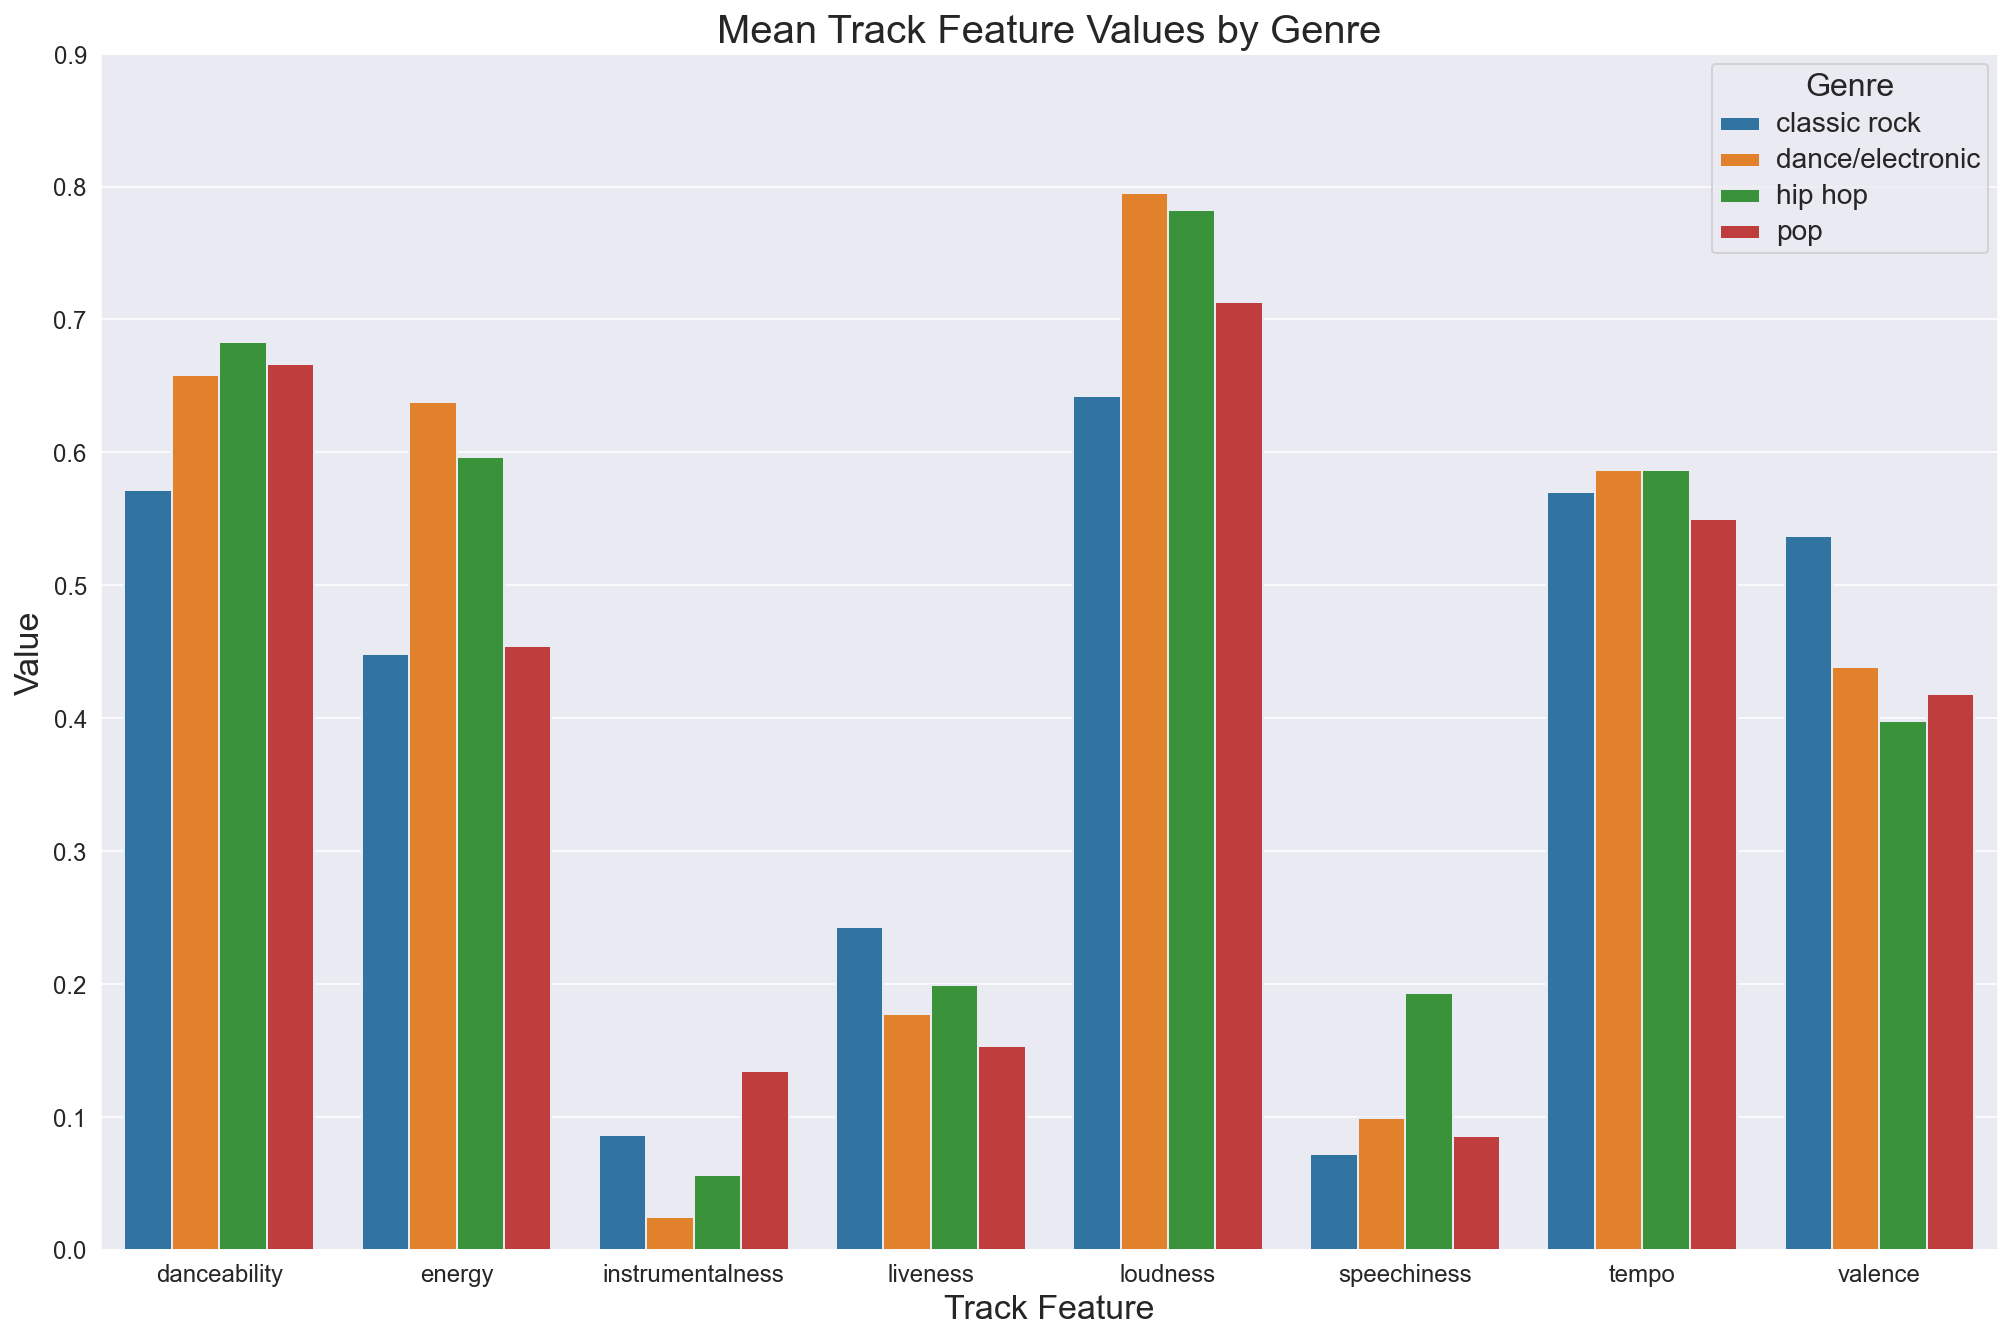

In [210]:
feature_averages_melted = pd.melt(feature_avgs_by_genre.reset_index(), id_vars='genre', var_name='track_feature')

fig, ax = plt.subplots(figsize=(17, 11))

sns.barplot(x='track_feature', y='value', hue='genre', data=feature_averages_melted, edgecolor='#EAEAF2')

plt.title('Mean Track Feature Values by Genre', fontsize=20)
plt.xlabel('Track Feature', fontsize=17)
plt.ylabel('Value', fontsize=17)
plt.xticks(ax.get_xticks(), size=12)
plt.yticks(ax.get_yticks(), size=12)
plt.legend(title='Genre')
plt.setp(ax.get_legend().get_texts(), fontsize='14')
plt.setp(ax.get_legend().get_title(), fontsize='16')
plt.show();

In [88]:
viz1_df_numeric = viz1_df.select_dtypes(np.number)



In [101]:
viz1_df_numeric = viz1_df.select_dtypes(np.number)
viz1_df_numeric

,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,0.554,0.535,0.000013,0.1240,-8.959,0.1860,105.865,0.136
1,0.556,0.630,0.004680,0.1550,-8.150,0.1020,149.147,0.367
2,0.545,0.641,0.000066,0.1710,-6.398,0.0998,121.892,0.464
3,0.780,0.689,0.000010,0.0698,-5.668,0.1410,115.042,0.642
4,0.903,0.519,0.000106,0.1550,-9.151,0.2600,114.991,0.587
...,...,...,...,...,...,...,...,...
1438,0.630,0.500,0.000040,0.1140,-8.755,0.0611,144.871,0.315
1439,0.511,0.399,0.000000,0.1130,-10.048,0.0930,137.023,0.394
1440,0.766,0.640,0.000000,0.2370,-8.899,0.0345,100.044,0.670
1441,0.643,0.521,0.000000,0.0896,-7.966,0.0516,159.964,0.678


In [108]:
scaler = MinMaxScaler()

viz1_df_scaled = pd.DataFrame(scaler.fit_transform(viz1_df_numeric), columns=viz1_df_numeric.columns)

viz1_df_scaled = pd.concat([viz1_df_scaled, viz1_df['genre']], axis=1)

viz1_df_scaled

,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,genre
0,0.589989,0.541807,0.000013,0.124498,0.740335,0.207127,0.513666,0.139918,dance/electronic
1,0.592119,0.642103,0.004785,0.155622,0.763692,0.113586,0.723674,0.377572,dance/electronic
2,0.580405,0.653716,0.000067,0.171687,0.814274,0.111136,0.591430,0.477366,dance/electronic
3,0.830671,0.704392,0.000010,0.070080,0.835349,0.157016,0.558193,0.660494,dance/electronic
4,0.961661,0.524916,0.000108,0.155622,0.734792,0.289532,0.557946,0.603909,dance/electronic
...,...,...,...,...,...,...,...,...,...
1438,0.670927,0.504856,0.000041,0.114458,0.746225,0.068040,0.702926,0.324074,dance/electronic
1439,0.544196,0.398226,0.000000,0.113454,0.708895,0.103563,0.664847,0.405350,dance/electronic
1440,0.815761,0.652660,0.000000,0.237952,0.742068,0.038419,0.485422,0.689300,dance/electronic
1441,0.684771,0.527027,0.000000,0.089960,0.769004,0.057461,0.776159,0.697531,dance/electronic


In [125]:
feature_avgs_by_genre = viz1_df_scaled.groupby('genre').mean()
feature_avgs_by_genre

,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
genre,,,,,,,,
classic rock,0.571838,0.448509,0.086360,0.242595,0.642179,0.072248,0.570364,0.536660
dance/electronic,0.658136,0.638177,0.024226,0.177141,0.795211,0.099202,0.586485,0.438757
hip hop,0.683327,0.596526,0.056036,0.199469,0.782060,0.193129,0.586827,0.397852
pop,0.666319,0.453931,0.134261,0.152999,0.713179,0.085348,0.549754,0.418487


In [114]:
list(feature_avgs_by_genre.columns)

['danceability',
 'energy',
 'instrumentalness',
 'liveness',
 'loudness',
 'speechiness',
 'tempo',
 'valence']

In [116]:
feature_avgs_by_genre.loc['classic rock']

danceability        0.571838
energy              0.448509
instrumentalness    0.086360
liveness            0.242595
loudness            0.642179
speechiness         0.072248
tempo               0.570364
valence             0.536660
Name: classic rock, dtype: float64

In [111]:
import plotly.graph_objects as go

In [123]:
categories = list(feature_avgs_by_genre.columns)

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=feature_avgs_by_genre.loc['classic rock'],
      theta=categories,
      name='Classic Rock'
))
fig.add_trace(go.Scatterpolar(
      r=feature_avgs_by_genre.loc['dance/electronic'],
      theta=categories,
      name='Dance/Electronic'
))
fig.add_trace(go.Scatterpolar(
      r=feature_avgs_by_genre.loc['hip hop'],
      theta=categories,
      name='Hip Hop'
))
fig.add_trace(go.Scatterpolar(
      r=feature_avgs_by_genre.loc['pop'],
      theta=categories,
      name='Pop'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 0.8]
    )),
  showlegend=True
)

fig.show()

In [134]:
feature_avgs_by_genre.reset_index()

,genre,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,classic rock,0.571838,0.448509,0.086360,0.242595,0.642179,0.072248,0.570364,0.536660
1,dance/electronic,0.658136,0.638177,0.024226,0.177141,0.795211,0.099202,0.586485,0.438757
2,hip hop,0.683327,0.596526,0.056036,0.199469,0.782060,0.193129,0.586827,0.397852
3,pop,0.666319,0.453931,0.134261,0.152999,0.713179,0.085348,0.549754,0.418487


In [146]:
test = pd.melt(feature_avgs_by_genre.reset_index(), id_vars='genre', var_name='track_feature')
test

,genre,track_feature,value
0,classic rock,danceability,0.571838
1,dance/electronic,danceability,0.658136
2,hip hop,danceability,0.683327
3,pop,danceability,0.666319
4,classic rock,energy,0.448509
5,dance/electronic,energy,0.638177
6,hip hop,energy,0.596526
7,pop,energy,0.453931
8,classic rock,instrumentalness,0.086360
9,dance/electronic,instrumentalness,0.024226


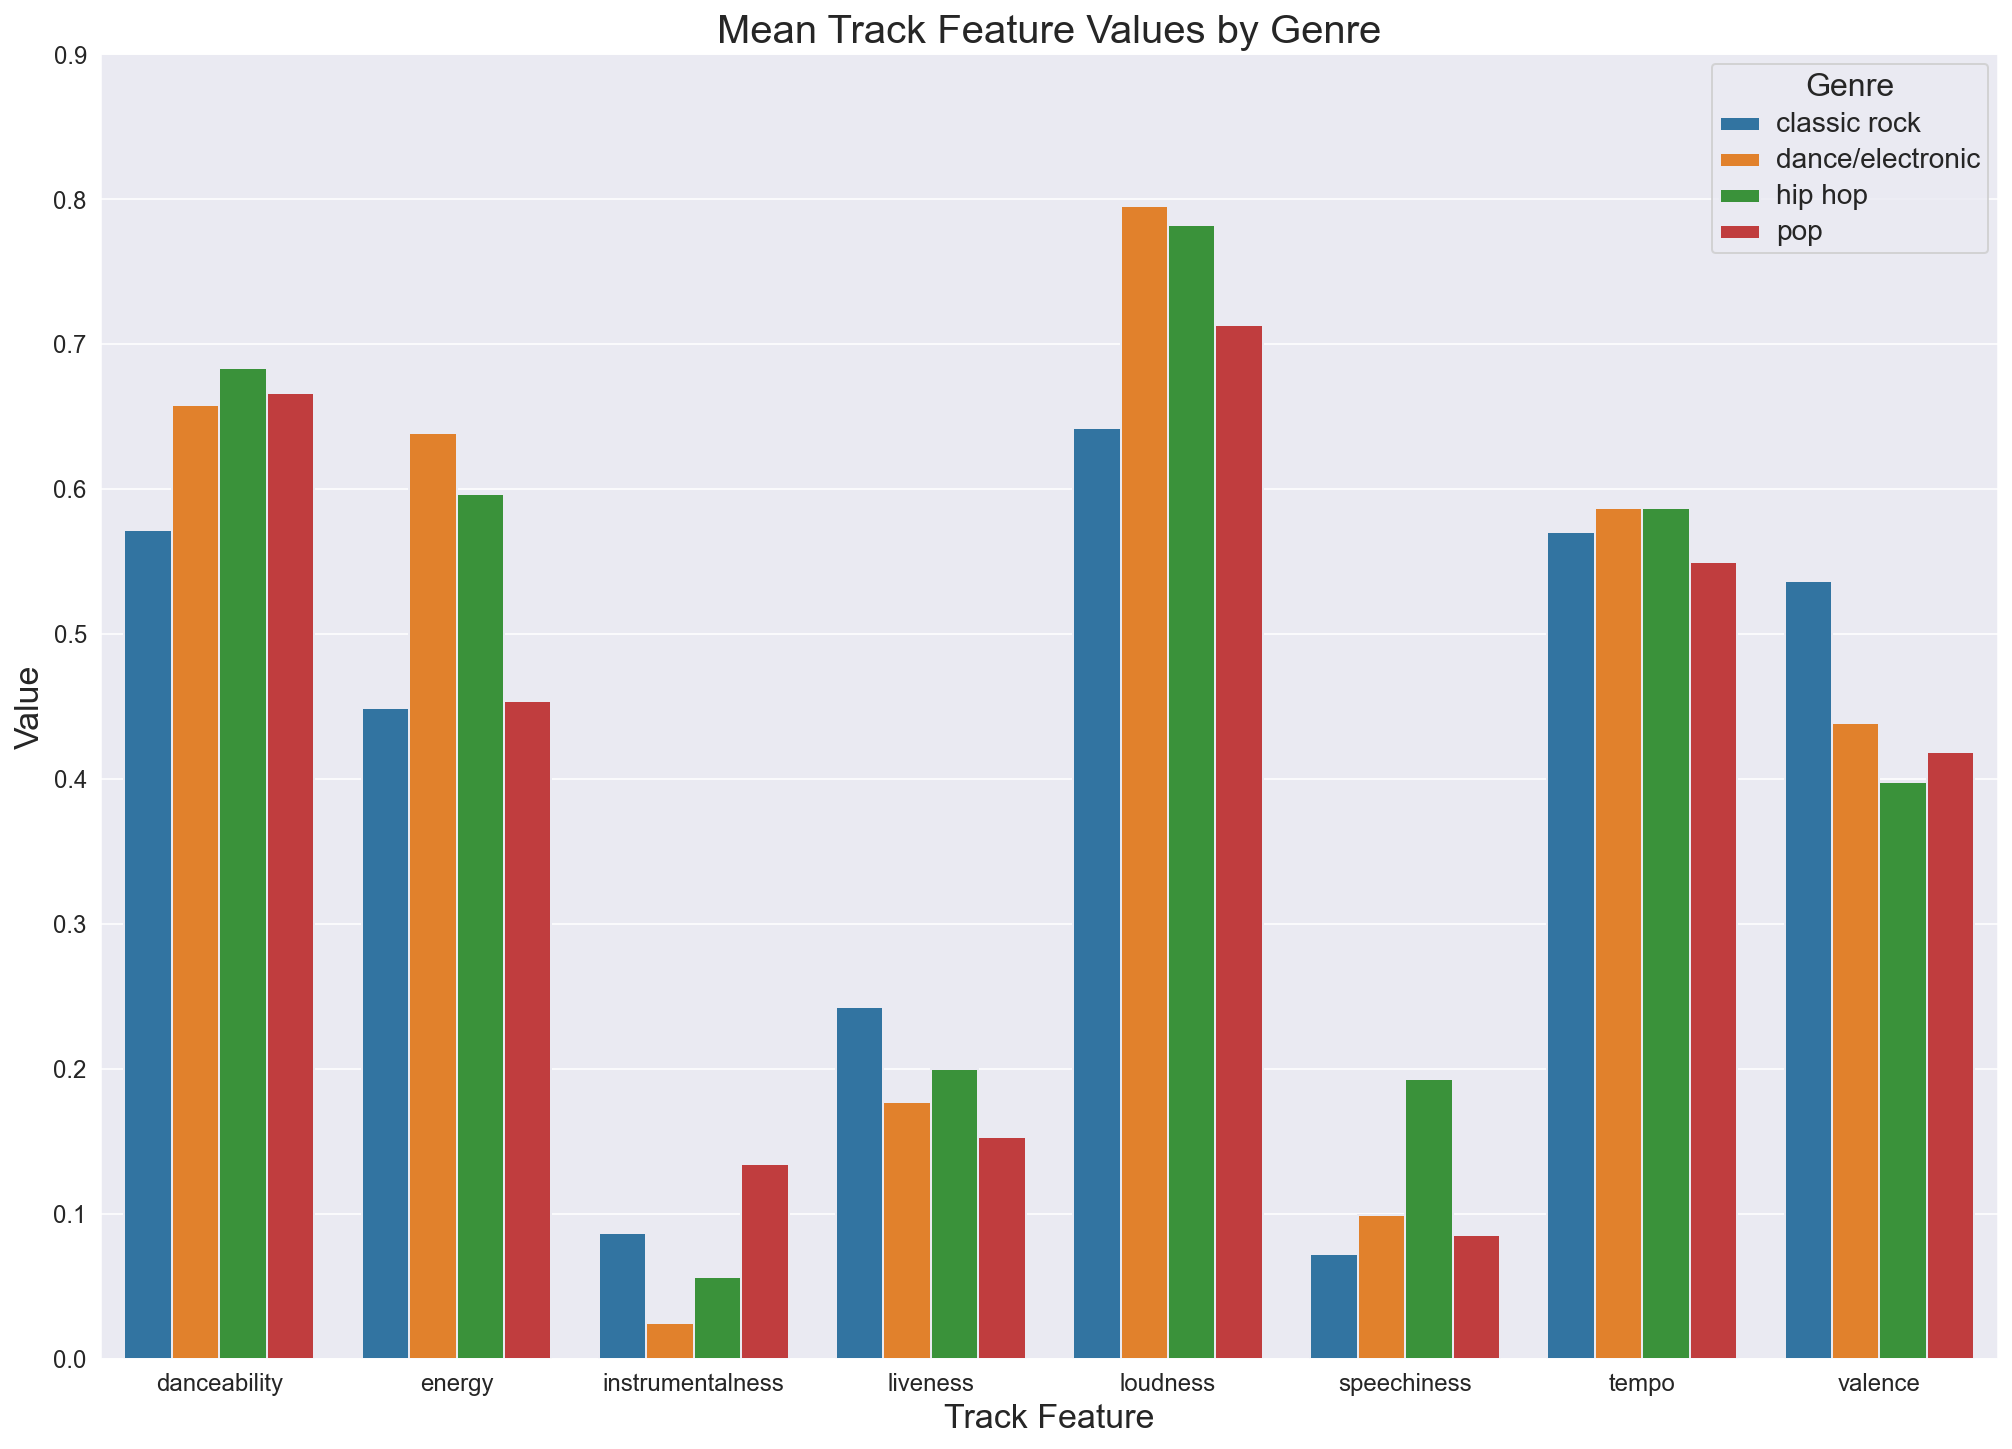

In [191]:
fig, ax = plt.subplots(figsize=(17, 12))

sns.barplot(x='track_feature', y='value', hue='genre', data=test, edgecolor='#EAEAF2')

plt.title('Mean Track Feature Values by Genre', fontsize=20)
plt.xlabel('Track Feature', fontsize=17)
plt.ylabel('Value', fontsize=17)
plt.xticks(ax.get_xticks(), size=12)
plt.yticks(ax.get_yticks(), size=12)
plt.legend(title='Genre')
plt.setp(ax.get_legend().get_texts(), fontsize='14')
plt.setp(ax.get_legend().get_title(), fontsize='16')
plt.show();

### 2.3: Evolution of Artists Visualized

In [209]:
viz3_df = artists_df[['artist_id', 'artist_name']].copy()

merge_df = albums_df[['album_id', 'artist_id', 'release_date']].copy()

viz3_df = merge_df.merge(viz3_df, on='artist_id')

viz3_df = tracks_df[['track_id', 'album_id']].merge(viz3_df, on='album_id')

viz3_df = track_features_df.merge(viz3_df, on='track_id').drop(columns=['type', 'song_uri'])

viz3_df

,track_id,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,album_id,artist_id,release_date,artist_name
0,1MpCaOeUWhox2Fgigbe1cL,0.554,0.535,0.000013,0.1240,-8.959,0.1860,105.865,0.136,6FJxoadUE4JNVwWHghBwnb,6vWDO969PvNqNYHIOW5v0m,2022-07-29,Beyoncé
1,0mKGwFMHzTprtS2vpR3b6s,0.556,0.630,0.004680,0.1550,-8.150,0.1020,149.147,0.367,6FJxoadUE4JNVwWHghBwnb,6vWDO969PvNqNYHIOW5v0m,2022-07-29,Beyoncé
2,1Hohk6AufHZOrrhMXZppax,0.545,0.641,0.000066,0.1710,-6.398,0.0998,121.892,0.464,6FJxoadUE4JNVwWHghBwnb,6vWDO969PvNqNYHIOW5v0m,2022-07-29,Beyoncé
3,1xzi1Jcr7mEi9K2RfzLOqS,0.780,0.689,0.000010,0.0698,-5.668,0.1410,115.042,0.642,6FJxoadUE4JNVwWHghBwnb,6vWDO969PvNqNYHIOW5v0m,2022-07-29,Beyoncé
4,0314PeD1sQNonfVWix3B2K,0.903,0.519,0.000106,0.1550,-9.151,0.2600,114.991,0.587,6FJxoadUE4JNVwWHghBwnb,6vWDO969PvNqNYHIOW5v0m,2022-07-29,Beyoncé
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1438,6y6jbcPG4Yn3Du4moXaenr,0.630,0.500,0.000040,0.1140,-8.755,0.0611,144.871,0.315,1TkwzY3l4LqAfrQwBAx45Q,2cFrymmkijnjDg9SS92EPM,2015-02-14,blackbear
1439,6pV8yBEHeu7A7lkttIjM2g,0.511,0.399,0.000000,0.1130,-10.048,0.0930,137.023,0.394,1TkwzY3l4LqAfrQwBAx45Q,2cFrymmkijnjDg9SS92EPM,2015-02-14,blackbear
1440,0qgZvYWLIqDn0tXimF8gPa,0.766,0.640,0.000000,0.2370,-8.899,0.0345,100.044,0.670,1TkwzY3l4LqAfrQwBAx45Q,2cFrymmkijnjDg9SS92EPM,2015-02-14,blackbear
1441,7ArrPiY7Xhl8J1bW2Ui0qy,0.643,0.521,0.000000,0.0896,-7.966,0.0516,159.964,0.678,1TkwzY3l4LqAfrQwBAx45Q,2cFrymmkijnjDg9SS92EPM,2015-02-14,blackbear
